COMP3362 Group Project - FPS Games with AI

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
module_dir = (
    "/content/drive/My Drive/Colab Notebooks/COMP3362_Project/"
)
# Add course material directory in Google Drive to system path, for importing .py files later
import sys
sys.path.append(module_dir)

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import torchvision
import torch
import numpy as np
import cv2
import argparse
import utils
from pylab import rcParams
import os
import torch.utils.data
from pycocotools.coco import COCO
import skimage.io as io
from torchvision.models.detection.keypoint_rcnn import KeypointRCNNPredictor
from PIL import Image
from torchvision.transforms import transforms as transforms
from engine import train_one_epoch, evaluate
import transforms as T
from torchvision.transforms import functional as F
from os.path import exists



transform = transforms.Compose([
    transforms.ToTensor()
])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class cocoDataset(torch.utils.data.Dataset):
    def __init__(self, annotation, amount, root = module_dir, transforms=None):
        self.root = root
        self.dataset = annotation
        self.transforms = transforms
        annpath = 'annotations/person_keypoints_{}.json'.format(annotation)
        annFile = os.path.join(module_dir, annpath)
        self.coco = COCO(annFile)
        catIds = self.coco.getCatIds(catNms=['person'])
        list_of_id = list(sorted(self.coco.getImgIds(catIds=catIds)))
        temp = []
        count = 0
        i = 0
        while (count<amount):
          file_id = list_of_id[i]
          name = self.coco.loadImgs(file_id)[0]['file_name']
          path_name = os.path.join(root,'images',annotation, name)
          if exists(path_name):
            temp.append(file_id)
            count +=1
          i+=1
        self.ids = temp
        print(self.ids)
        print(len(self.ids))
    
    def __getitem__(self, index):
        # get cocoapi
        coco = self.coco

        # get image id, ann id
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)

        #load image
        filename = coco.loadImgs(img_id)[0]['file_name']
        path = os.path.join( 'images',self.dataset, filename)
        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        num_objs = len(coco_annotation)

        # produce pytorch format data
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        img_id = torch.tensor([img_id])

        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        keypoints = []
        for i in range(num_objs):
            points = coco_annotation[i]['keypoints']
            middle = []
            for i in range(0,9,3):
                threept = [points[i],points[i+1],points[i+2]]
                middle.append(threept)
            # comment next 3 lines for 7 keypoints
            for i in range(9,15,3):
                threept = [0,0,0]
                middle.append(threept)
            for i in range(15,21,3):
                threept = [points[i],points[i+1],points[i+2]]
                middle.append(threept)
            # comment next 3 lines for 7 keypoints
            for i in range(21,33,3):
                threept = [0,0,0]
                middle.append(threept)
            for i in range(33,39,3):
                threept = [points[i],points[i+1],points[i+2]]
                middle.append(threept)
            # comment next 3 lines for 7 keypoints
            for i in range(39,51,3):
                threept = [0,0,0]
                middle.append(threept)
            keypoints.append(middle)
        keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
        
        final_annotation = {}
        final_annotation["boxes"] = boxes
        final_annotation["labels"] = labels
        final_annotation["image_id"] = img_id
        final_annotation["area"] = areas
        final_annotation["iscrowd"] = iscrowd
        final_annotation["keypoints"] = keypoints
        if self.transforms is not None:
            img, final_annotation = self.transforms(img, final_annotation)
        else:
            img , final_annotation = F.to_tensor(img), final_annotation

        return img, final_annotation

    def __len__(self):
        return len(self.ids)

In [5]:
def get_transform():
    transform = []
    transform.append(T.ToTensor())
    return T.Compose(transform)

In [6]:
dataset = cocoDataset(annotation='train2017', transforms=get_transform(), amount=500)
dataset_test = cocoDataset(annotation='val2017', transforms=None , amount=50)
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=utils.collate_fn)


loading annotations into memory...
Done (t=11.16s)
creating index...
index created!
[165, 192, 201, 241, 257, 260, 294, 308, 315, 322, 326, 328, 338, 357, 360, 368, 370, 382, 389, 395, 397, 415, 419, 428, 431, 436, 443, 446, 459, 471, 474, 488, 510, 520, 529, 531, 532, 536, 542, 544, 564, 569, 572, 589, 623, 625, 634, 641, 659, 673, 684, 690, 692, 693, 716, 722, 723, 730, 731, 735, 761, 764, 781, 790, 795, 810, 821, 828, 831, 836, 839, 882, 897, 901, 913, 923, 925, 927, 934, 943, 960, 962, 965, 969, 974, 984, 985, 999, 1006, 1011, 1014, 1053, 1089, 1098, 1102, 1107, 1108, 1144, 1145, 1146, 1149, 1164, 1176, 1180, 1183, 1200, 1204, 1216, 1232, 1237, 1244, 1270, 1271, 1290, 1292, 1295, 1298, 1307, 1308, 1311, 1315, 1319, 1330, 1332, 1342, 1350, 1359, 1360, 1369, 1375, 1381, 1390, 1397, 1398, 1401, 1403, 1404, 1407, 1424, 1431, 1436, 1451, 1453, 1464, 1488, 1523, 1527, 1536, 1548, 1554, 1563, 1569, 1579, 1580, 1586, 1591, 1592, 1596, 1599, 1626, 1637, 1639, 1655, 1667, 1668, 1670, 1700, 1

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [7]:
def get_model(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, num_keypoints=17, num_classes = num_classes)
    # model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
    #                                                                pretrained_backbone=True,
    #                                                                num_keypoints = 7,
    #                                                                num_classes = num_classes)
    return model


In [8]:
num_classes = 2
num_epochs = 10
model = get_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.002,
#                                 momentum=0.9, weight_decay=0.0005)

# trial 
optimizer = torch.optim.SGD(params, lr=0.01,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)
len_dataloader = len(data_loader)



Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth


  0%|          | 0.00/226M [00:00<?, ?B/s]

In [9]:
# evaluate(model, data_loader_test, device)  #bug exist

In [10]:
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    # evaluate(model, data_loader_test, device=device)

        

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/250]  eta: 0:11:26  lr: 0.000050  loss: 2.1529 (2.1529)  loss_classifier: 0.0103 (0.0103)  loss_box_reg: 0.0347 (0.0347)  loss_keypoint: 2.1040 (2.1040)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 2.7451  data: 0.8433  max mem: 1976
Epoch: [0]  [ 10/250]  eta: 0:08:03  lr: 0.000451  loss: 3.4521 (3.4028)  loss_classifier: 0.1314 (0.1107)  loss_box_reg: 0.1767 (0.1532)  loss_keypoint: 2.9169 (3.0122)  loss_objectness: 0.0064 (0.0752)  loss_rpn_box_reg: 0.0186 (0.0515)  time: 2.0150  data: 0.0845  max mem: 4008
Epoch: [0]  [ 20/250]  eta: 0:07:26  lr: 0.000853  loss: 3.5884 (3.4278)  loss_classifier: 0.0655 (0.0981)  loss_box_reg: 0.0826 (0.1408)  loss_keypoint: 2.9221 (3.1086)  loss_objectness: 0.0086 (0.0467)  loss_rpn_box_reg: 0.0100 (0.0334)  time: 1.9012  data: 0.0101  max mem: 4008
Epoch: [0]  [ 30/250]  eta: 0:07:02  lr: 0.001254  loss: 3.6158 (3.4354)  loss_classifier: 0.0533 (0.1000)  loss_box_reg: 0.0889 (0.1473)  loss_keypoint: 

In [11]:
torch.save(model.state_dict(), os.path.join(module_dir,'keypointsrcnn_17k.pth'))

In [12]:
rcParams['figure.figsize'] = 15, 12

def show_image(path):
    image = plt.imread(path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [13]:
def draw_keypoints_and_boxes(outputs, image):
    # the `outputs` is list which in-turn contains the dictionary 
    for i in range(len(outputs[0]['keypoints'])):
        # get the detected keypoints
        keypoints = outputs[0]['keypoints'][i].cpu().detach().numpy()
        # get the detected bounding boxes
        boxes = outputs[0]['boxes'][i].cpu().detach().numpy()

        # proceed to draw the lines and bounding boxes 
        if outputs[0]['scores'][i] > 0.7: # proceed if confidence is above 0.9
            keypoints = keypoints[:, :].reshape(-1, 3)
            for p in range(keypoints.shape[0]):
                # draw the keypoints
                cv2.circle(image, (int(keypoints[p, 0]), int(keypoints[p, 1])), 
                            3, (0, 0, 255), thickness=-1, lineType=cv2.FILLED)

            cv2.rectangle(image, (int(boxes[0]), int(boxes[1])), (int(boxes[2]), int(boxes[3])),
                          color=(0, 255, 0), 
                          thickness=2)
        else:
            continue

    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


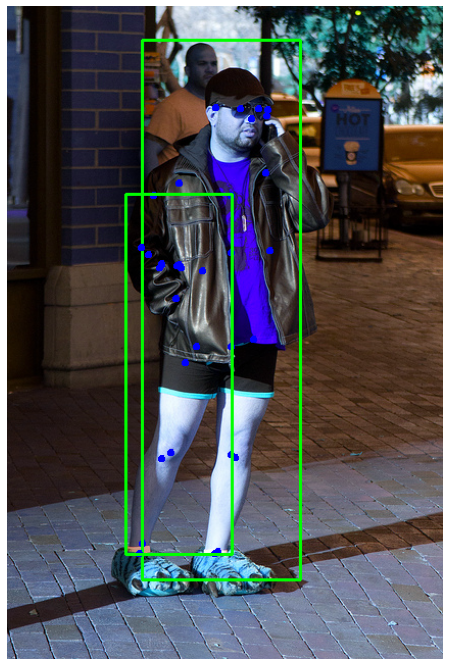

In [14]:
model.eval()
image_path = os.path.join(module_dir, "images/train2017/000000001006.jpg")
image = Image.open(image_path).convert('RGB')
orig_numpy = np.array(image, dtype=np.float32)
# convert the NumPy image to OpenCV BGR format
orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
image = transform(image)
image = image.unsqueeze(0).to(device)
with torch.no_grad():
    outputs = model(image)

output_image = draw_keypoints_and_boxes(outputs, orig_numpy)
plt.imshow(output_image)
plt.axis('off')
plt.show()

In [15]:
image_path = os.path.join(module_dir, "screenshots/test.jpeg")
image = Image.open(image_path).convert('RGB')
orig_numpy = np.array(image, dtype=np.float32)
# convert the NumPy image to OpenCV BGR format
orig_numpy = cv2.cvtColor(orig_numpy, cv2.COLOR_RGB2BGR) / 255.
image = transform(image)
image = image.unsqueeze(0).to(device)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


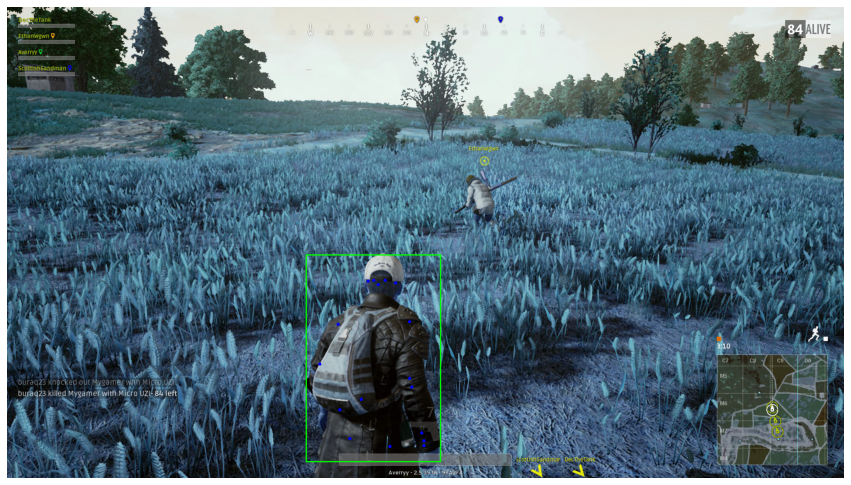

In [16]:
with torch.no_grad():
    outputs = model(image)

output_image = draw_keypoints_and_boxes(outputs, orig_numpy)
plt.imshow(output_image)
plt.axis('off')
plt.show()